# Springboard Data Science Career Track Program

## Capstone Project 1 - DonorsChoose Final Report

#### Irene Yao
#### November 26, 2018

### <font color=#3090C7>Introduction</font>

DonorsChoose.org is a non-profit education crowdfunding platform that allows individuals to donate directly to public school classroom projects. Since its inception in 2000, the organization has helped to fund more than 1,200,000 projects which reached out to more than 31,000,000 students. In this project, we will be diving into the datasets collected from DonorsChoose.org’s open data platform to explore an assortment of factors that may affect the project’s success rate. In addition, we will perform a donor clustering using a similarity measure to produce groupings of donors. With the analysis, we are hoping to help the organization to observe the shared features among different donors and projects and potentially find an approach to better match its projects with the most relevant donor groups.

### <font color=#3090C7>Description of Dataset</font>

This analysis is based on open data from DonorsChoose.org’s open data platform. The datasets used include the Project data and the Donation data, which are downloaded separately and merged together using the _projectid column. The joined table contains more than 6 million entries (rows), each refers to an individual donation made toward a certain project. The _donationid is the unique key of each entry. 

### Data Wrangling

1. *Feature Selection:* I started with features selected from the data and pruned the variables to only include the relevant columns.     
  
  
2. *Memory Optimization:* After inspecting the data table by performing df.info(memory_usage='deep'), we noticed that the biggest problem with the dataset is that it consumes more than 12.9GB of memory. The data frame has 3 data types: float, integer and object. The object type data is the one that consumes the most memory. Since most of the object data are categorical data in our dataset, converting them to the type 'category' will save a lot of memory. However, we don't want to convert all the object columns to 'category' if they don't have a few unique values. As a result, we only want to convert columns where less than 50% of the values are unique. After the optimization, we observed that the memory usage decreased from 12.9GB to 2GB.


3. *Filling in Missing Values:* There are some missing values in the school_city column. This is the location of the school raising funds for a project. To fill in the missing values, I map the city according to the corresponding school district. However, some of the school districts cover more than one city. Thus, we can't infer the corresponding city from the district name. By applying the above mapping, we were able to decrease the null value in the school_city column from more than 50,000 to 12,673.


4. *Save the Optimized Data:* the optimized dataset after data wrangling was saved as a pickled file for easy extraction for future use. 



### Exploratory Data Analysis & Statistical Analysis

The exploratory data analysis (EDA) provides insights from different perspectives including donations, projects, teachers, and how the user base grew over time. To make the analysis more relevant to the US market, we will only look at donations that happened in US.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
%matplotlib inline  
pd.options.display.max_columns = None
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_pickle('project_donation_optimized.pkl')

In [3]:
## get US dataset by mapping the states
xl = pd.ExcelFile('state_long_lat.xlsx')
lon_lat_map = xl.parse('state_long_lat')
us_states = lon_lat_map['State_Short']
df_us = df[(df['donor_state'].notnull()) & (df['donor_state'].isin(us_states))]

#### Donation Analysis

##### Donors & Donations

To start with, we will run some general numbers from the dataset including total number of donors and donations to see how many donors are actively using the website to make contributions. The data shows that as of October 2016, there are 1,786,756 registered donors on the platform, who have made a total contribution of $362,873,020.

In [4]:
## total number of donors
donor_number = df_us['_donor_acctid'].nunique()
total_donation = df_us['donation_total'].sum()
print("As of October 2016, there are " + 
      str(donor_number) + 
      """ registered donors on DonorsChoose, who have made a total contribution of """ + 
      str(total_donation) + " dollars.")

As of October 2016, there are 1786756 registered donors on DonorsChoose, who have made a total contribution of 362873020.0 dollars.


Next, I would love to see among all the users, how many are multiple-time versus single-time donors. I will show a bar graph which depicts the count for each donation frequency. 

In [5]:
donation_count = df_us.groupby('_donor_acctid').size().to_frame().reset_index()
donation_count.columns = ['donor_id', 'donation_count']
#donation_count.head()
donation_freq = donation_count['donation_count'].value_counts(ascending=False).to_frame().reset_index()
donation_freq.columns = ['donation_frequency', 'count']
donation_freq.head()

,donation_frequency,count
0,1,1318268
1,2,250701
2,3,85637
3,4,40662
4,5,23093


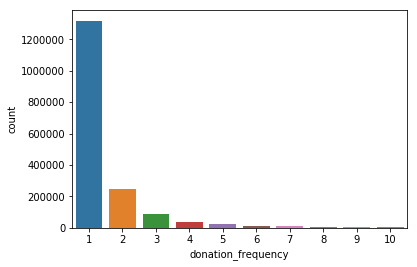

In [6]:
sns.barplot(x='donation_frequency', y='count', data=donation_freq.head(10))

Out of the 1,786,756 donors, majority (1,318,268) of them have only donated once, and only 26% are frequent donors.

##### Donation Distribution

It is interesting to see how different states are using the service and where the donations are concentrated. This can be reflected in both the number of donations and total donation amount in each state.

In [7]:
donor_state_count = df_us.groupby(df_us['donor_state'].astype('object')).size().sort_values(ascending=False)
max_donor_state = donor_state_count.head(10)
min_donor_state = donor_state_count.tail(10)

In [8]:
state_don_amt = df_us.groupby(df_us['donor_state'].astype('object'))['donation_total'].sum().sort_values(ascending=False)
max_state_amt = state_don_amt.head(10)
min_state_amt = state_don_amt.tail(10)

Text(0, 0.5, 'Amount')

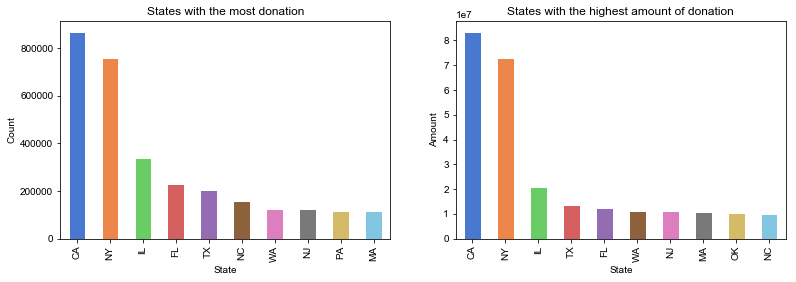

In [9]:
### states with the most donation
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(13, 4))
sns.set_style('white')
sns.set_palette('muted')
ax0.set_title('States with the most donation')
ax1.set_title('States with the highest amount of donation')
max_donor_state.plot.bar(ax=ax0)
max_state_amt.plot.bar(ax=ax1)
ax0.set_xlabel('State')
ax0.set_ylabel('Count')
ax1.set_xlabel('State')
ax1.set_ylabel('Amount')

Text(0, 0.5, 'Amount')

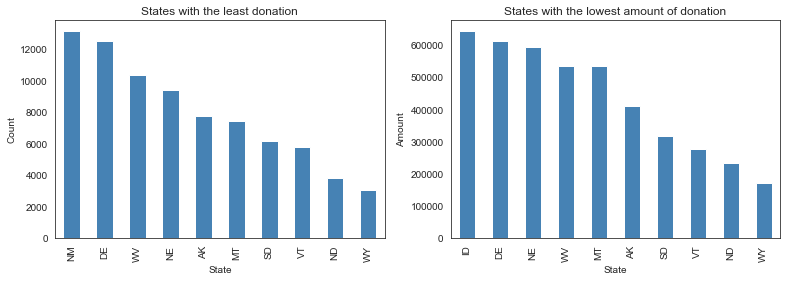

In [10]:
### states with the least donation
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(13, 4))
sns.set_style('white')
ax0.set_title('States with the least donation')
ax1.set_title('States with the lowest amount of donation')
min_donor_state.plot.bar(ax=ax0, color='steelblue')
min_state_amt.plot.bar(ax=ax1, color='steelblue')
ax0.set_xlabel('State')
ax0.set_ylabel('Count')
ax1.set_xlabel('State')
ax1.set_ylabel('Amount')

We can see from above that among all the states, California and New York rank as the top 2 states with respect to amount donated, and number of projects for which donations were sent. However, the top states are also the states with the largest population. I suspect that there is a positive correlation between number of donations and state population. I will add the population data obtained from the Census Bureau, which includes the population of each state as of 2016.
Population data: https://www2.census.gov/programs-surveys/popest/datasets/2010-2017/state/asrh/

In [11]:
## get US population data
state_map = dict(zip(lon_lat_map['State'], lon_lat_map['State_Short']))
pop_df = pd.read_csv('population_data.csv')
pop_2016 = pop_df[['NAME', 'POPESTIMATE2016']]
pop_2016 = pop_2016.loc[5:55]
pop_2016 = pop_2016[pop_2016['NAME']!='District of Columbia']
pop_2016.columns = ['State', '2016_Population']
pop_2016['State_Short'] = pop_2016['State'].map(state_map)
pop_map = dict(zip(pop_2016['State_Short'], pop_2016['2016_Population']))
#pop_2016.head()

(0, 1320596.9799049615)

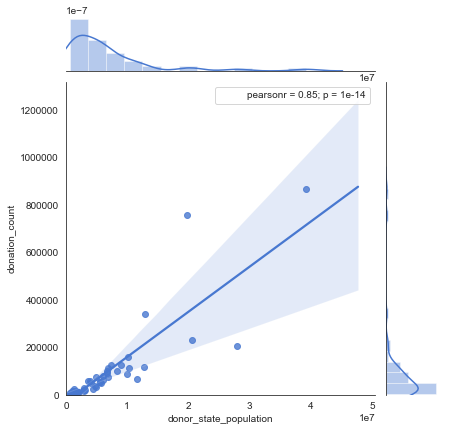

In [12]:
df_us['donor_state_population'] = df_us['donor_state'].map(pop_map)
don_pop = df_us.groupby(['donor_state', 'donor_state_population'])['donor_state'].size()
don_pop = don_pop.to_frame()
don_pop.columns = ['donation_count']
don_pop = don_pop.reset_index()

g = sns.jointplot('donor_state_population', 'donation_count', data=don_pop, kind='reg')
g.annotate(stats.pearsonr)
plt.xlim(left=0)
plt.ylim(bottom=0)

The joint plot above demonstrates a strong positive correlation between the state population and the number of donations from the state with a pearson correlation r equals 0.85. The small p-value suggests the strong evidence that the correlation is statistically significant. Therefore, we can conclude that more donations are collected from states with a larger population.

Since we know that the population is associated with the number of donations, it would be more intuitive to compare the per capita donation within the state instead of total number of donations. We would add a donation_ratio column and investigate if there's any difference between different states.

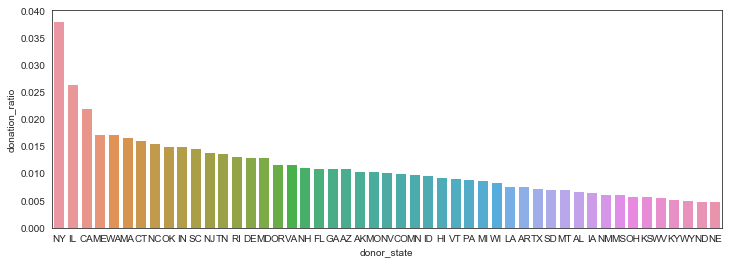

In [13]:
don_pop['donation_ratio'] = (don_pop['donation_count']/don_pop['donor_state_population'])
don_state = don_pop[['donor_state', 'donation_ratio']].sort_values('donation_ratio', ascending=False)
plt.figure(figsize=(12,4))
sns.barplot(x='donor_state', y='donation_ratio', data=don_state, order=don_state['donor_state'])

In [14]:
don_pop[don_pop['donation_ratio']>=0.02]

,donor_state,donor_state_population,donation_count,donation_ratio
4,CA,39296476.0,869925,0.022137
13,IL,12835726.0,339851,0.026477
33,NY,19836286.0,757193,0.038172


After calculating the donations on a per capita basis, we can still observe the difference among states. In fact, New York, Illinois, and California are still the top 3 states with the highest per capita donation.

### Project Analysis

##### Count & Amount

In [15]:
print(df_us['_projectid'].nunique())
print(df_us['date_posted'].max())

924255
2016-10-11 00:00:00


As of October 2016, there are in total 924,255 projects posted on the website. In order to see how the number of projects has grown over time, we will break the numbers down into different years. We also notice that for the projects posted on the platform, they can either be completed or expired without enough donation. We would also like to see the trends in fully-funded projects.

In [16]:
df_us['project_year'] = df_us['date_posted'].dt.year
df_us['complete_year'] = df_us['date_completed'].dt.year

In [17]:
### projects posted over time
project_over_time = df_us.groupby('project_year')['_projectid'].nunique()
completed_projects = df_us[df_us['funding_status']=='completed']
completed_over_time = completed_projects.groupby('complete_year')['_projectid'].nunique()

Text(0, 0.5, 'Count')

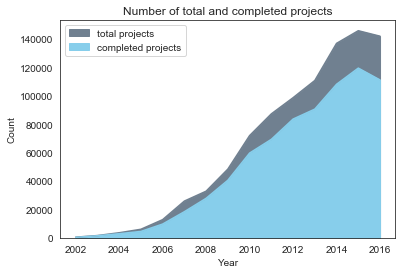

In [18]:
sns.set_style('white')
fig, ax = plt.subplots()
project_over_time.plot.area(ax=ax, label='total projects', color='slategrey')
completed_over_time.plot.area(ax=ax, label='completed projects',color='skyblue')
ax.set_title('Number of total and completed projects')
ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('Count')

The project flow started to pick up in a fast pace starting around year 2006. A quick research on the company's Wikipedia page reveals that the organization has been given Charity Navigator's highest rating every year since 2005. This corresponds to the high growth path revealed in the chart.

Now we have an idea of the project volume, let's take a look at the donation amount associated with each project. We will identify the projects with the most donation count, highest donation amount, and the average donation of all the completed projects.

In [19]:
## project donation size
total_donation_per_project = completed_projects.groupby('_projectid')['donation_total'].sum()
total_donation_per_project = total_donation_per_project.sort_values(ascending=False)
average_donation = total_donation_per_project.mean()
average_donation

457.025634765625

In [20]:
## max donation size
print('highest donation amount: ' + str(total_donation_per_project.max()))
print('max number of donation: ' + str(completed_projects['num_donors'].max()))

highest donation amount: 186951.77
max number of donation: 848


In [21]:
print(total_donation_per_project.sort_values(ascending=False).head(1))

_projectid
bbbc6cccccd3c1bc8c44ec494bb6cf23    186951.765625
Name: donation_total, dtype: float32


In [22]:
completed_projects[completed_projects['_projectid']=='bbbc6cccccd3c1bc8c44ec494bb6cf23'].head(2)

,_donationid,_projectid,_donor_acctid,donor_city,donor_state,is_teacher_acct,donation_timestamp,donation_to_project,donation_optional_support,donation_total,payment_method,is_teacher_referred,thank_you_packet_mailed,_teacher_acctid,school_ncesid,school_latitude,school_longitude,school_city,school_state,school_zip,school_metro,school_district,school_county,teacher_prefix,primary_focus_subject,primary_focus_area,secondary_focus_subject,secondary_focus_area,resource_type,poverty_level,grade_level,total_price_excluding_optional_support,total_price_including_optional_support,students_reached,total_donations,num_donors,eligible_double_your_impact_match,eligible_almost_home_match,funding_status,date_posted,date_completed,date_thank_you_packet_mailed,date_expiration,donor_state_population,project_year,complete_year
254134,01d72050cfc5714eb5f9bde7f2a1e2f0,bbbc6cccccd3c1bc8c44ec494bb6cf23,4242433cbedd23bf0f4f3ff22eb17ccc,NaN,OR,0,2015-12-03 14:04:45.633,425.00,75.00,500.0,paypal,0,f,ba835ad62be9d5f38b2e54a8edbf83fb,NaN,40.839062,-73.900124,New York City,NY,10457.0,urban,New York Dept Of Education,Bronx,Mr.,Gym & Fitness,Health & Sports,NaN,NaN,Supplies,highest poverty,Grades 3-5,217377.015625,255737.671875,999.0,249253.3125,313,t,f,completed,2015-08-28,2015-12-28,NaT,2016-01-29,4085989.0,2015,2015.0
254136,01dd0a7985b986793d9d6ae6204023b0,bbbc6cccccd3c1bc8c44ec494bb6cf23,0e210f62f3f0cb27598664a7f0116b09,NaN,NY,0,2015-12-01 23:38:29.281,21.25,3.75,25.0,creditcard,0,f,ba835ad62be9d5f38b2e54a8edbf83fb,NaN,40.839062,-73.900124,New York City,NY,10457.0,urban,New York Dept Of Education,Bronx,Mr.,Gym & Fitness,Health & Sports,NaN,NaN,Supplies,highest poverty,Grades 3-5,217377.015625,255737.671875,999.0,249253.3125,313,t,f,completed,2015-08-28,2015-12-28,NaT,2016-01-29,19836286.0,2015,2015.0


In [23]:
completed_projects[completed_projects['num_donors']==848]
completed_projects[completed_projects['_projectid']=='c34218abf3fecd36be01305d67ed7fbb'].head(2)

,_donationid,_projectid,_donor_acctid,donor_city,donor_state,is_teacher_acct,donation_timestamp,donation_to_project,donation_optional_support,donation_total,payment_method,is_teacher_referred,thank_you_packet_mailed,_teacher_acctid,school_ncesid,school_latitude,school_longitude,school_city,school_state,school_zip,school_metro,school_district,school_county,teacher_prefix,primary_focus_subject,primary_focus_area,secondary_focus_subject,secondary_focus_area,resource_type,poverty_level,grade_level,total_price_excluding_optional_support,total_price_including_optional_support,students_reached,total_donations,num_donors,eligible_double_your_impact_match,eligible_almost_home_match,funding_status,date_posted,date_completed,date_thank_you_packet_mailed,date_expiration,donor_state_population,project_year,complete_year
17863,0009d2759ff78b89a8b85b95ffc1e921,c34218abf3fecd36be01305d67ed7fbb,9437d67acc13a0643c8667c019602b9d,NaN,CA,0,2015-05-29 01:04:07.193,84.150002,14.85,99.0,creditcard,1,f,7fe6dd0c1af5f911e9bc38030cfb4ced,6.112201e+10,38.006054,-122.552521,San Rafael,CA,94903.0,suburban,Dixie School District,Marin,Ms.,Health & Wellness,Health & Sports,Literacy,Literacy & Language,Supplies,moderate poverty,Grades 3-5,93563.90625,110075.1875,350.0,109333.476562,848,f,f,completed,2015-05-26,2015-08-12,2015-12-21,2015-10-24,39296476.0,2015,2015.0
17864,0019498f1881b4ab7462e92a08df5c14,c34218abf3fecd36be01305d67ed7fbb,306961a477a046e184d4e708f718111f,NaN,PA,0,2015-06-25 08:53:17.245,40.000000,0.00,40.0,creditcard,1,f,7fe6dd0c1af5f911e9bc38030cfb4ced,6.112201e+10,38.006054,-122.552521,San Rafael,CA,94903.0,suburban,Dixie School District,Marin,Ms.,Health & Wellness,Health & Sports,Literacy,Literacy & Language,Supplies,moderate poverty,Grades 3-5,93563.90625,110075.1875,350.0,109333.476562,848,f,f,completed,2015-05-26,2015-08-12,2015-12-21,2015-10-24,12787085.0,2015,2015.0


The average donations per project is around `$`450. The project with the highest donation amount is a project completed in 2015. It was posted by a teacher in New York City to raise funds for gyms and fitness purpose. The project was sponsored by 313 donors with a total donation amount of `$`86,951.77. The project with the most number of donors is a project for an elementary school in San Rafael, CA. The funds are used to support Literacy development and raised `$`93,563.91 from 848 donors.

With the drastic growth in number of posted projects, it would be important to also measure the turnaround rate. I am curious to know whether it's taking longer or shorter for each project to be completed.

In [24]:
### average time for projects to be completed
df_complete = df_us[df_us['funding_status']=='completed']
df_complete['days_to_complete'] = (df_complete['date_completed']-df_complete['date_posted']).dt.days
df_complete= df_complete[['_projectid', 'project_year', 'days_to_complete']].drop_duplicates()

In [25]:
#df_complete.head()
df_complete_nan = df_complete.dropna()

In [26]:
average_completion_days = df_complete.groupby('project_year')['days_to_complete'].mean()
#average_completion_days.values

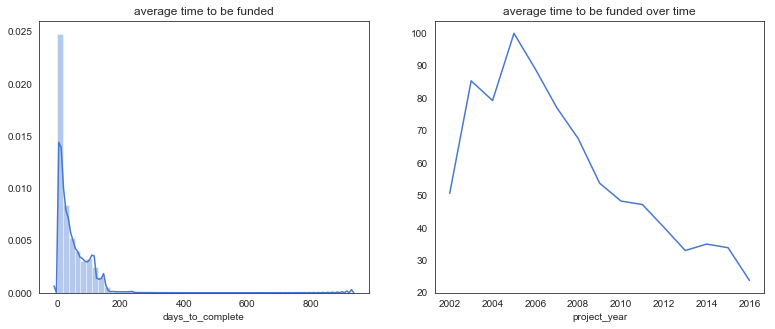

In [27]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(13, 5))
sns.set_style('white')
ax0.set_title('average time to be funded')
ax1.set_title('average time to be funded over time')
sns.distplot(df_complete_nan['days_to_complete'], ax = ax0)
sns.lineplot(x=average_completion_days.index, y=average_completion_days.values, ax = ax1)

The majority of the projects are fully-donated within 100 days, and the turnaround keeps decreasing with more and more people start using the platform. The projects that are posted recently were completed within around a month.

##### Project Completion Time vs. Primary Focus Area

DonorsChoose placed projects into 7 different focus areas and I'm curious to see if the time periods to complete the donations are the same for different categories. Since the platform wasn't getting a lot of volume before 2006. The projects posted back then created many outliers in terms of completion time. For the analysis purpose, I will only use the projects posted between 2006 and 2016.

In [28]:
### average time for projects to be completed - project focus
df_complete_recent = df_us[(df_us['funding_status']=='completed') & (df_us['date_posted']>='2006-01-01')]
df_complete_recent['days_to_complete'] = (df_complete_recent['date_completed']-df_complete_recent['date_posted']).dt.days
df_complete_recent= df_complete_recent[['_projectid', 'primary_focus_area', 'days_to_complete', 'donation_total']].drop_duplicates()
mean_comp_days = df_complete_recent.groupby('primary_focus_area')['days_to_complete'].mean()
print(mean_comp_days)

primary_focus_area
Applied Learning       43.045365
Health & Sports        35.078756
History & Civics       41.731956
Literacy & Language    42.343375
Math & Science         40.364388
Music & The Arts       43.296106
Special Needs          43.593827
Name: days_to_complete, dtype: float64


The means look similar among different subjects. I'll do a Tukey’s Range Test to see if the means are actually the same.

H0: the mean time it takes to complete the donation for reach subject area is the same.

HA: there is a significant difference in the mean time to complete the donation among different subject areas.


In [29]:
df_complete_recent = df_complete_recent.dropna()
v = df_complete_recent['days_to_complete']
labels = df_complete_recent['primary_focus_area']

### Tukey
tukey_results = pairwise_tukeyhsd(v, labels, 0.05)
print(tukey_results)

           Multiple Comparison of Means - Tukey HSD,FWER=0.05          
       group1              group2       meandiff  lower   upper  reject
-----------------------------------------------------------------------
  Applied Learning    Health & Sports   -7.9666   -8.49  -7.4432  True 
  Applied Learning    History & Civics  -1.3134  -1.8376 -0.7892  True 
  Applied Learning  Literacy & Language  -0.702  -1.0581 -0.3458  True 
  Applied Learning     Math & Science    -2.681  -3.0514 -2.3105  True 
  Applied Learning    Music & The Arts   0.2507  -0.1726  0.6741 False 
  Applied Learning     Special Needs     0.5485   0.0872  1.0097  True 
  Health & Sports     History & Civics   6.6532   6.0807  7.2257  True 
  Health & Sports   Literacy & Language  7.2646   6.8406  7.6887  True 
  Health & Sports      Math & Science    5.2856   4.8495  5.7217  True 
  Health & Sports     Music & The Arts   8.2174   7.7355  8.6992  True 
  Health & Sports      Special Needs     8.5151   7.9996  9.0305

Text(33.99999999999999, 0.5, '')

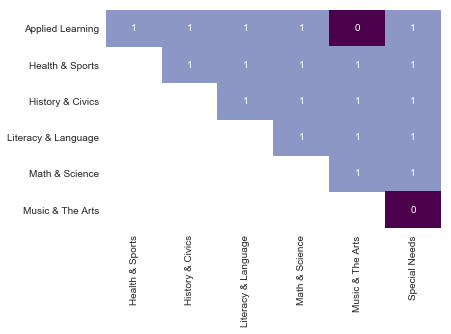

In [48]:
subjects = tukey_results.groupsunique
groups=[]
for i in range(len(subjects)):
    for j in range(i+1, len(subjects)):
        groups.append((subjects[i], subjects[j]))
groups_df = pd.DataFrame(groups)
groups_df.columns=['Group1', 'Group2']
groups_df['Reject'] = tukey_results.reject
groups_df['Reject'] = [1 if i==True else 0 for i in groups_df['Reject']]
groups_df_pivot = groups_df.pivot('Group1', 'Group2', 'Reject')
ax = sns.heatmap(groups_df_pivot, cmap='BuPu_r', center=1, cbar=False, annot=True)
plt.xlabel('')
plt.ylabel('')

The Tukey test suggests that in most cases, we can reject the null hypothesis and conclude that the difference in mean time to complete the donation in different subject areas are statistically significant.    
(The grid with number 0 means that we cannot reject the null hypothesis and the grid with number 1 means that the null hypothesis can be rejected.)

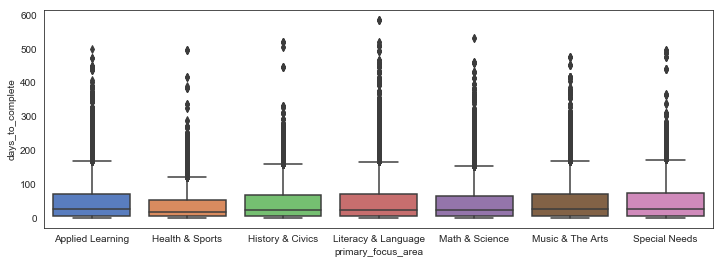

In [49]:
plt.figure(figsize=(12,4))
sns.boxplot(x='primary_focus_area', y='days_to_complete', data=df_complete_recent)

Health & Sports has the lowest mean and the narrowest interquartile range. It is the category that requires the least time to collect donation. 

##### Projects vs. Grade Levels

The projects are raised for schools from PreK to grade 12. From the below chart, it is clear that most of the fundings are demanded in elementary level, especially among lower grades.

In [50]:
projects_grade = df_us.groupby('grade_level')['_projectid'].nunique()

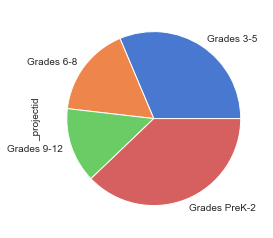

In [51]:
sns.set_style('white')
sns.set_palette('muted')
fig, ax = plt.subplots(1, 1)
ax.set_ylabel('')
projects_grade.plot(kind='pie', ax=ax)

##### Projects vs. Poverty Level

In [52]:
projects_pov = df_us.groupby('poverty_level')['_projectid'].nunique()

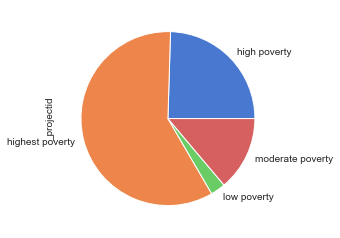

In [53]:
sns.set_style('white')
sns.set_palette('muted')
projects_pov.plot(kind='pie')

It makes sense that more donations are needed where the poverty level is high with limited government funding. 

##### Projects vs. Focus Area

With the current trends in tech development, schools are focusing more on technology-related education such as STEM. To see if the donation requests match the trend, we will divide the projects into different subject areas.

In [54]:
project_focus_area = df_us.groupby('primary_focus_area')['_projectid'].nunique().sort_values(ascending=False)

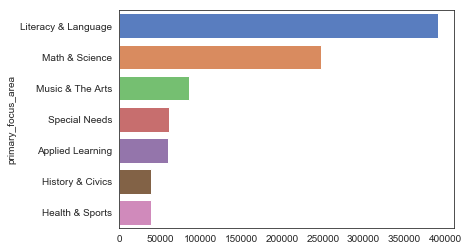

In [55]:
sns.set_palette('muted')
sns.barplot(x=project_focus_area.values, y=project_focus_area.index, order=project_focus_area.index)

Indeed, teachers are requesting more support in Literacy & Language and Math & Science categories. But was this the trend since the beginning?

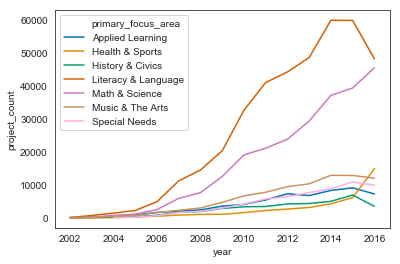

In [40]:
project_focus_area = df_us.groupby(['project_year','primary_focus_area'])['_projectid'].nunique()
project_focus_area = project_focus_area.to_frame().reset_index()
project_focus_area.columns = ['year', 'primary_focus_area', 'project_count']
sns.set_palette('colorblind')
sns.lineplot(data=project_focus_area, x='year', y='project_count', hue='primary_focus_area')

While all projects exhibit an upward trend, demand in Math & Science and Literacy & Language have grown more rapidly than the rest. While most of the projects have started to slow down since 2015, projects in Math & Science continued to expand. Let’s take a look at the pattern when we break down the data by poverty level.

In [56]:
focus_poverty = df_us.groupby(['primary_focus_area', 'poverty_level'])['_projectid'].nunique()
focus_poverty = focus_poverty.to_frame().reset_index()
focus_poverty.head()

,primary_focus_area,poverty_level,_projectid
0,Applied Learning,high poverty,14880
1,Applied Learning,highest poverty,35671
2,Applied Learning,low poverty,1595
3,Applied Learning,moderate poverty,7892
4,Health & Sports,high poverty,9673


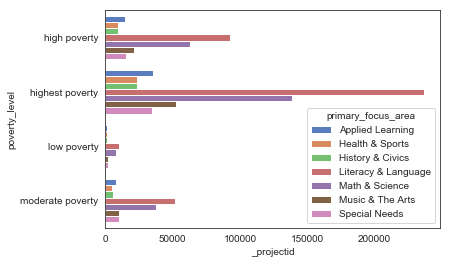

In [57]:
sns.barplot(x='_projectid', y='poverty_level', hue='primary_focus_area', data=focus_poverty)

Despite different wealth levels among schools, Literacy & Language and Math & Science are always on the top of the bucket list.

### Teacher Analysis

The projects on the platform are teacher-driven. Let's first take a look at the total teacher population over years.

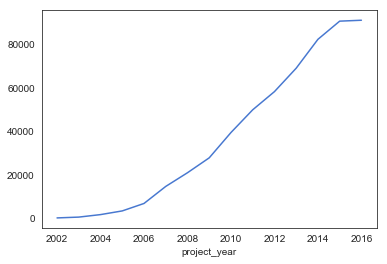

In [58]:
teacher_count = df_us.groupby('project_year')['_teacher_acctid'].nunique()
teacher_count
sns.set_style('white')
teacher_count.plot()

Teacher users have more than doubled from year 2010 to 2016. It exhibits a positive correlation with the project growth.

Next, I would like to see how many projects are posted by female teachers vs. male teachers.

In [59]:
df_us['teacher_gender'] = ['Female' if i in ['Mrs.', 'Ms.'] else 'Male' if i=='Mr.' else 'Unknown' for i in df_us['teacher_prefix']] 

In [61]:
## number of teachers posting projects over years
teacher_over_time = df_us.groupby(['project_year', 'teacher_gender'])['_teacher_acctid'].nunique()
teacher_over_time = teacher_over_time.to_frame().reset_index()
teacher_over_time.columns = ['year', 'teacher_gender', 'teacher_count']
#teacher_over_time

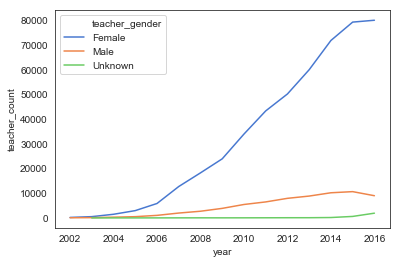

In [62]:
sns.lineplot(data=teacher_over_time, x='year', y='teacher_count', hue='teacher_gender')

We can spot that the number of male teachers grew very little and majority of the projects are posted by female teachers. That's probably because female are more prevalent in teaching positions. 

Would the teacher's gender have any influence on the success rate of the donation? Let's compare the projects posted by female teachers and male teachers to see if there is a significant difference by applying the Chi-square test. 


H0: there is no difference in the donation completion rate between male and female teachers

H1: there is a significant difference in the donation completion rate between male and female teachers

Significance level: 0.05


In [63]:
### build a chi-square contingency table
male_total = df_us[(df_us['funding_status']!='live') & (df_us['teacher_gender']=='Male')]['_projectid'].nunique()
male_complete = df_us[(df_us['funding_status']=='completed') & (df_us['teacher_gender']=='Male')]['_projectid'].nunique()
male_incomplete = male_total - male_complete
female_total = df_us[(df_us['funding_status']!='live') & (df_us['teacher_gender']=='Female')]['_projectid'].nunique()
female_complete = df_us[(df_us['funding_status']=='completed') & (df_us['teacher_gender']=='Female')]['_projectid'].nunique()
female_incomplete = female_total - female_complete

x = [[male_complete, male_incomplete], [female_complete, female_incomplete]]
print(x)

[[92002, 18311], [651946, 133464]]


In [64]:
print('donation completion rate by male teachers: ', (male_complete/male_total))
print('donation completion rate by female teachers: ', (female_complete/female_total))

donation completion rate by male teachers:  0.8340086843799008
donation completion rate by female teachers:  0.830070918373843


In [65]:
## chi-square test
chi2, pval, dof, expected = stats.chi2_contingency(x)
print('p-value: ', pval)
print(chi2)

p-value:  0.0011129774259750452
10.62950100655928


At a 0.05 significance level, the null hypothesis that female teachers and male teachers achieve the same donation completion rate can be rejected. Although we spot that the average completion rate for projects posted by both male and female teacher are around 83%, there is a 0.4% difference in the sample data. The difference is small but statistically significant. 

### Conclusions from EDA

With the above exploratory analysis, we can observe the following:
* Out of the massive number of donors online, only 26% has donated more than once. 
* California and New York are the two states that hosted most of the donations. These are also the two states that have the biggest population. New York, Illinois, and California are the top 3 states with the highest percentage of population that donated. 
* Project volume has grown rapidly in the past 10 years and the time to collect donation has decreased drastically. 
* Health & Sports tends to raise money quickly compared to other categories.
* Lower grades in elementary schools need the most financing support, especially in schools that are located in high-poverty regions. 
* Despite the poverty level, Literacy & Language and Math & Science are the categories that need the most funding. These two subjects have been more dominating in the recent years. 

### Machine Learning - K-means Clustering 

get donation summary for each donor

In [ ]:
df_m = df_us[['_donor_acctid', 'donation_total', 'primary_focus_area']]
df_m.head() 